# Part-of-speech Tagger con Keras
Luca Casini - Elaborazione del Linguaggio Naturale - A.A. 2016/2017


## Introduzione
Lo scopo di questo progetto è creare un *Part-of-Speech Tagger*, ossia un programma che prende in input un testo ed è in grado di etichettare correttamente le parti di un discorso. L'approccio classico al problema si basa su modelli probabilistici come le Hidden Markov Machines ma negli ultimi anni i modelli basati sulle reti neurali, il cosidetto *deep learning*, sono diventati lo stato dell'arte.

Ho quindi deciso di sperimentare con queste tecnologie utilizzando la libreria **Keras** che permette di sviluppare modelli di deep learning con relativa facilità.

In [4]:
import keras
from keras.preprocessing import text
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.utils import to_categorical


import numpy as np
import pandas as pd

from collections import Counter
import string


## Dataset 
I dati utilizzati sono quelli resi disponibili per la prova di PoS-tagging di **EVALITA 2009**. Il dataset è composto da 108,875 parole divise in 3,719 frasi ognuna delle quali è annotata con un tag dell'insieme **Tanl**, un tagset compatibile con lo standard internazionale EAGLES e composto da 14 classi divisibili a loro volta in 37 classi più fini che possono essere corredate da informazioni morfologiche per arrivare fino a 336 tag. Il file di partenza contiene anche le informazioni morfologiche ma le ho scartate decidendo di tenere solo l'insieme fine da 37 tag.

In [5]:
# Apriamo il dataset utilizzando pandas
data = pd.read_table("PoSTaggingCorpus/train", sep="\s*")

# questa funzione serve a utilizzare solo parte maiuscola del tag.
# questa corrisponde al tagset fine grained senza informazioni sulla morfologia della parola
def removeLower(tag):
    t = tag.translate(None,string.ascii_lowercase)
    t = t.translate(None,string.digits)
    return t

# insieme delle parole nel nostro dataset. un valore per il padding
words = list(set(data.words))
words.append("<PADDING>")
n_words = len(words)
tags = list(set([removeLower(t) for t in data.tags]))
tags.append("<P>")
n_tags = len(tags)

print "#words:",n_words,"#tags:",n_tags

print words[-1],tags[-1] # controllare se gli elementi di padding sono inseriti in coda
print sorted(tags)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


#words: 17315 #tags: 39
<PADDING> <P>
['<P>', 'A', 'AP', 'B', 'BN', 'CC', 'CS', 'DD', 'DE', 'DI', 'DQ', 'DR', 'E', 'EA', 'FB', 'FC', 'FF', 'FS', 'I', 'N', 'NO', 'PC', 'PD', 'PE', 'PI', 'PP', 'PQ', 'PR', 'RD', 'RI', 'S', 'SA', 'SP', 'SW', 'T', 'V', 'VA', 'VM', 'X']


Dopo aver creato il nostro *dizionario* di parole e tag, è necessario creare un insieme di tutte le frasi che serviranno poi ad allenare la rete neurale

In [6]:
txt = open("PoSTaggingCorpus/train","r")
txt.readline()
txt.readline()
line = txt.readline()
sentences = []
sn = []
while line:
    if line == "\n":
       # print "LINEEND",sn
        sentences.append(sn)
        sn = []
        line = txt.readline()
    else: 
        #print "word"
        ln = line.split("\t")
        ln[1] = ln[1].strip("\n")
        sn.append((ln[0],removeLower(ln[1])))
        line = txt.readline()

#print "#sentecses:",len(sentences) 
#print sentences[0]

Alla base della nostra rete neurale c'è un **word embdedding** ossia una rappresentazione vettoriale del nostro dizionario. In un word embdedding le relazioni tra le parole vengono catturate dalla loro posizione del campo vettoriale.


In [7]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
print word2idx["<PADDING>"]

tag2idx = {t: i for i, t in enumerate(tags)}
print tag2idx["<P>"]

17315
38


In [9]:
max_len = max([len(s) for s in sentences]) #longest sentence

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["<PADDING>"])
# X is the value for the residual class
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["<P>"])


In [10]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [11]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.05)
X_te.shape

(186, 175)

## Rete Neurale

L'architettura che in letteratura sembra ottenere i risultati migliori è costituita da una LSTM che prende in input un word embedding seguita da un CRF. L'ho implementata utilizzando Keras che permette di costruire il modello con un interfaccia di alto livello senza dover entrare nei dettagli dei singoli componenti.

Come anticipato il livello di Embedding crea una rappresentazione vettoriale del nostro vocabolario e permette alla rete neurale di cogliere le relazioni sintattiche che ci sono tra le parole.

Le LSTM (long short-time memory) sono un tipo di rete neurale ricorrente che è in grado di considerare anche i passi temporali precendenti quando analizza una sequenza, conservando una *memoria* del contensto. Questo livello viene incapsulato dal livello `Bidirectional` che fa in modo che la sequenza venga elaborata in entrambi i sensi in modo che per ogni parola sia disponibile il contesto che la precede e che la succede.

I CRF (conditional random field) sono un modello probabilistico molto utilizzato con le sequenze di dati che costruiscono le proprie predizioni considerando la distribuzione dell'intera sequenza piuttosto che procedere passo per passo.



In [29]:
input_layer = Input(shape=(max_len,))

model = Embedding(input_dim=n_words + 1, output_dim=20,input_length=max_len, mask_zero=True)(input_layer)
model = Bidirectional(LSTM(units=32, return_sequences=True, recurrent_dropout=0.2))(model)  
model = Bidirectional(LSTM(units=32, return_sequences=True, recurrent_dropout=0.2))(model)  
model = TimeDistributed(Dense(64, activation="elu"))(model)

crf = CRF(n_tags)

output_layer = crf(model)

model = Model(input_layer, output_layer)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()
history = None

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 175)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 175, 20)           346320    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 175, 64)           13568     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 175, 64)           24832     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 175, 64)           4160      
_________________________________________________________________
crf_4 (CRF)                  (None, 175, 39)           4134      
Total params: 393,014
Trainable params: 393,014
Non-trainable params: 0
_________________________________________________________________


In [47]:
History = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=4,
                    validation_split=0.1, verbose=1)
if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])

Train on 3179 samples, validate on 354 samples
Epoch 1/4
3179/3179 [==============================] - 143s 45ms/step - loss: 0.1203 - viterbi_acc: 0.9645 - val_loss: 0.1279 - val_viterbi_acc: 0.9638
Epoch 2/4
3179/3179 [==============================] - 141s 44ms/step - loss: 0.0934 - viterbi_acc: 0.9748 - val_loss: 0.1123 - val_viterbi_acc: 0.9687
Epoch 3/4
3179/3179 [==============================] - 141s 44ms/step - loss: 0.0731 - viterbi_acc: 0.9817 - val_loss: 0.1001 - val_viterbi_acc: 0.9744
Epoch 4/4
3179/3179 [==============================] - 140s 44ms/step - loss: 0.0594 - viterbi_acc: 0.9853 - val_loss: 0.0936 - val_viterbi_acc: 0.9757


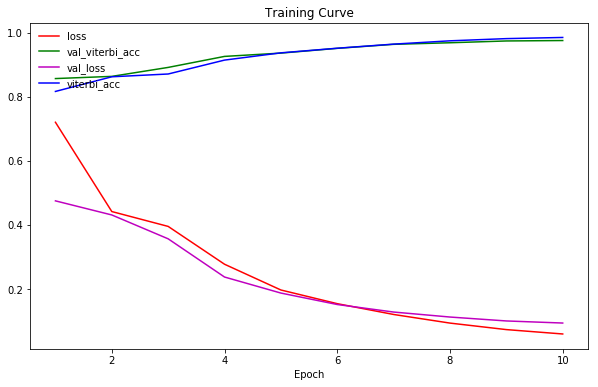

In [48]:
from matplotlib import pyplot as plt

def plot_traincurve(history):
    # define 4 colors for up to 4 different values in history
    colors = {'loss':'r', 'viterbi_acc':'b', 'val_loss':'m', 'val_viterbi_acc':'g'}
    plt.figure(figsize=(10,6))
    plt.title("Training Curve") 
    plt.xlabel("Epoch")


    for measure in history.keys():
        color = colors[measure]
        ln = len(history[measure])
        plt.plot(range(1,ln+1), history[measure], color + '-', label=measure)  # use last 2 values to draw line

    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)
    
plot_traincurve(history)


## Testing

una volta allenato il modello è il momento di vericarne le prestazioni sul test set che abbiamo creato prima.

La funzione `acc_score` calcola quale percentuale delle predizioni fatte dal modello è corretta ponendo attenzione a non considerare il padding nel calcolo, questi valori infatti vengono sempre individuati correttamente.

La funzione `testSentence` valuta una singola frase e se si desidera stampa una lista in cui compare il tag predetto e quello effettivo.

L'ultima funzione valuta tutte le frasi che compongono il test set e poi restituisce la media dei valori di *accuracy*, dando così un idea delle prestazioni complessive del modello.

In [50]:
def acc_score(pred, test):
    r = 0.0
    c = 0.0
    for i,p in enumerate(pred):
        if test[i] == tag2idx["<P>"]:
            break
        else:
            r += 1
            if p == test[i]:
                c += 1.0
            
    #print c,"out of",r
    return c / r 

In [55]:
def testSentence(i, verbose=False):
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    true = np.argmax(y_te[i], -1)

    if verbose:
        #print p,true
        print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
        print(30 * "=")
        for w, t, pred in zip(X_te[i], true, p[0]):
            if w != word2idx["<PADDING>"]:
                print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))
    
    return acc_score(p[0],true)

testSentence(2, True)

Word           ||True ||Pred
Le             : RD    RD
parti          : S     S
si             : PC    PC
reincontreranno: V     V
domani         : B     B
,              : FF    FF
i              : RD    RD
poligrafici    : S     A
hanno          : VA    VA
già           : B     B
minacciato     : V     V
altre          : DI    N
ore            : S     S
di             : E     E
sciopero       : S     S
nel            : EA    EA
caso           : S     S
la             : RD    RD
trattativa     : S     S
si             : PC    PC
irrigidisse    : V     V
ulteriormente  : B     B
.              : FS    FS


0.9130434782608695

In [53]:
res = []
for i,_ in enumerate(X_te):
    print i,"\r",
    res.append(testSentence(i))
#print res
print np.mean(res)

0.85664961878
